# Introduction 
This project consists in analysing the last 30 years measured wind in Dublin and the possible relationship to the climate change using the synoptic station in Dublin_Airport, Co Dublin. 
Source: https://data.gov.ie/dataset/dublin-airport-hourly-data

### 1.1 Preparing the environment
First, we must prepare the necessary working environment to start the analysis problem. This introductory section is divided as follows:
- Library installation.
- Load the dataset
- Check the DF info 

First we need to explore and to anderstand the dataset, to run the program we need to import necessary libraries, like pandas and datetime.

In [2]:

# import DataFrames
import pandas as pd

# import dates and times
import datetime as dt

# import numpy
import numpy as np

# import os 
import os 

# import matplotlib
import matplotlib.pyplot as plt



Adding the dataset and verify if this was loaded properly.

In [3]:
# Load the dataset
# Skip the first 23 lines which contain metadata, then read the CSV
df = pd.read_csv("wind.csv", skiprows=23)

/tmp/ipykernel_5580/3178886404.py:3: DtypeWarning: Columns (8,9,14,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("wind.csv", skiprows=23)


In [4]:
# Display the first rows
df.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
0,01-jan-1945 00:00,2,0.0,0,4.9,0,4.6,4.4,8.2,95,...,1,0,1,0,50,4,0.0,200,2,8
1,01-jan-1945 01:00,3,0.0,0,5.1,0,4.9,4.4,8.5,97,...,1,0,1,0,45,4,0.0,200,2,8
2,01-jan-1945 02:00,2,0.0,0,5.1,0,4.8,4.4,8.5,97,...,1,0,1,0,50,4,0.0,4800,4,8
3,01-jan-1945 03:00,0,0.2,0,5.2,0,5.0,4.4,8.5,97,...,1,0,1,0,50,4,0.0,6000,4,8
4,01-jan-1945 04:00,2,0.0,0,5.6,0,5.4,5.0,8.8,97,...,1,7,1,250,50,5,0.0,6000,4,8


To have more information about the dataset and check what info it's usfull for the annalysis we can use: 
- The df.shape to have: number of rows, number of columns
- The df.info to obtain: a summary of the DataFrame.

In [5]:
# number of rows and columns
df.shape


(709297, 21)

In [6]:
# info of the data frame
df.info

<bound method DataFrame.info of                      date  ind  rain  ind.1  temp  ind.2  wetb  dewpt vappr  \
0       01-jan-1945 00:00    2   0.0      0   4.9      0   4.6    4.4   8.2   
1       01-jan-1945 01:00    3   0.0      0   5.1      0   4.9    4.4   8.5   
2       01-jan-1945 02:00    2   0.0      0   5.1      0   4.8    4.4   8.5   
3       01-jan-1945 03:00    0   0.2      0   5.2      0   5.0    4.4   8.5   
4       01-jan-1945 04:00    2   0.0      0   5.6      0   5.4    5.0   8.8   
...                   ...  ...   ...    ...   ...    ...   ...    ...   ...   
709292  30-nov-2025 20:00    0   0.6      0   7.0      0   6.6    6.0   9.4   
709293  30-nov-2025 21:00    2   0.0      0   9.7      0   8.4    7.0  10.0   
709294  30-nov-2025 22:00    0   1.2      0   9.7      0   8.9    8.0  10.8   
709295  30-nov-2025 23:00    0   0.7      0  10.0      0   9.2    8.3  11.0   
709296  01-dec-2025 00:00    0   0.3      0  10.8      0   9.8    8.8  11.3   

       rhum  ...  i

We can use 'describe' method to check the dispersion and shape of a dataset’s distribution, excluding NaN values.

In [7]:
# describe the data frame
df.describe()

,ind,rain,ind.1,temp,ind.2,wetb,dewpt,msl,ind.3,wdsp,ind.4,ww,w,sun
count,709297.000000,709297.000000,709297.000000,709297.000000,709297.000000,709297.000000,709297.000000,709297.000000,709297.000000,709297.000000,709297.000000,709297.000000,709297.000000,709297.000000
mean,0.632851,0.086648,0.014224,9.664489,0.029308,8.224054,6.603725,1013.584091,1.353533,10.114264,1.353712,15.596149,17.181295,0.167409
std,1.101539,0.418524,0.118687,4.893245,0.257702,4.409004,4.592909,12.347392,0.808965,5.680150,0.809007,22.553069,24.214145,0.326679
min,0.000000,0.000000,0.000000,-11.500000,0.000000,-11.500000,-17.700000,944.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,6.100000,0.000000,5.100000,3.300000,1006.200000,1.000000,6.000000,1.000000,2.000000,2.000000,0.000000
50%,0.000000,0.000000,0.000000,9.700000,0.000000,8.400000,6.900000,1014.800000,2.000000,9.000000,2.000000,2.000000,11.000000,0.000000
75%,2.000000,0.000000,0.000000,13.200000,0.000000,11.600000,10.000000,1022.200000,2.000000,14.000000,2.000000,21.000000,11.000000,0.100000
max,6.000000,26.500000,2.000000,29.100000,6.000000,22.200000,20.500000,1048.700000,6.000000,46.000000,7.000000,97.000000,99.000000,1.000000


We can rename the columns we need, to have an understandable names.

In [8]:
# rename the columns

df = df.rename(columns={
    'date': 'date and time', 
    'temp': 'air temperature', 
    'wdsp': 'mean wind speed', 
    'wddir': 'wind direction'})
df.head()

,date and time,ind,rain,ind.1,air temperature,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,mean wind speed,ind.4,wind direction,ww,w,sun,vis,clht,clamt
0,01-jan-1945 00:00,2,0.0,0,4.9,0,4.6,4.4,8.2,95,...,1,0,1,0,50,4,0.0,200,2,8
1,01-jan-1945 01:00,3,0.0,0,5.1,0,4.9,4.4,8.5,97,...,1,0,1,0,45,4,0.0,200,2,8
2,01-jan-1945 02:00,2,0.0,0,5.1,0,4.8,4.4,8.5,97,...,1,0,1,0,50,4,0.0,4800,4,8
3,01-jan-1945 03:00,0,0.2,0,5.2,0,5.0,4.4,8.5,97,...,1,0,1,0,50,4,0.0,6000,4,8
4,01-jan-1945 04:00,2,0.0,0,5.6,0,5.4,5.0,8.8,97,...,1,7,1,250,50,5,0.0,6000,4,8


Delete the columns we don't need. Example 'sun'columns are not needed because it's not a value of a category in analysis.

In [9]:
# delete the columns
df = df.drop(columns=['wetb', 'dewpt', 'vappr', 'sun', 'msl', 'w' ,'ww', 'vis', 'clht', 'clamt'])
df.head()


,date and time,ind,rain,ind.1,air temperature,ind.2,rhum,ind.3,mean wind speed,ind.4,wind direction
0,01-jan-1945 00:00,2,0.0,0,4.9,0,95,1,0,1,0
1,01-jan-1945 01:00,3,0.0,0,5.1,0,97,1,0,1,0
2,01-jan-1945 02:00,2,0.0,0,5.1,0,97,1,0,1,0
3,01-jan-1945 03:00,0,0.2,0,5.2,0,97,1,0,1,0
4,01-jan-1945 04:00,2,0.0,0,5.6,0,97,1,7,1,250


We will delete 'ind'columns because they are not needed due it's not a value of a category in analysis. To delete several columns starting with the word 'ind' even if we have another value after the word, we can use the startswith() method. 

Source: https://www.w3schools.com/python/ref_string_startswith.asp

In [10]:
# delete the columns
df = df.loc[:, ~df.columns.str.startswith('ind')]
df.head()

,date and time,rain,air temperature,rhum,mean wind speed,wind direction
0,01-jan-1945 00:00,0.0,4.9,95,0,0
1,01-jan-1945 01:00,0.0,5.1,97,0,0
2,01-jan-1945 02:00,0.0,5.1,97,0,0
3,01-jan-1945 03:00,0.2,5.2,97,0,0
4,01-jan-1945 04:00,0.0,5.6,97,7,250


Verify the df.types, to know if we need to change the datetime format, for better analysis.

In [11]:
df.dtypes

date and time       object
rain               float64
air temperature    float64
rhum                object
mean wind speed      int64
wind direction      object
dtype: object

Date and time already is a dataframe, however to ensure the code consider this as a dataframe we can explicit say it.

In [12]:
df['date and time'] = df['date and time'].astype('datetime64[ns]')

# Set the 'Date and Time' column as the index
df.set_index('date and time', inplace=True)
df = df.sort_index()
df.head()


,rain,air temperature,rhum,mean wind speed,wind direction
date and time,,,,,
1945-01-01 00:00:00,0.0,4.9,95,0,0
1945-01-01 01:00:00,0.0,5.1,97,0,0
1945-01-01 02:00:00,0.0,5.1,97,0,0
1945-01-01 03:00:00,0.2,5.2,97,0,0
1945-01-01 04:00:00,0.0,5.6,97,7,250


In [13]:
# verify the columns
df.columns

Index(['rain', 'air temperature', 'rhum', 'mean wind speed', 'wind direction'], dtype='object')

In [14]:
# verify the index
df.index


DatetimeIndex(['1945-01-01 00:00:00', '1945-01-01 01:00:00',
               '1945-01-01 02:00:00', '1945-01-01 03:00:00',
               '1945-01-01 04:00:00', '1945-01-01 05:00:00',
               '1945-01-01 06:00:00', '1945-01-01 07:00:00',
               '1945-01-01 08:00:00', '1945-01-01 09:00:00',
               ...
               '2025-11-30 15:00:00', '2025-11-30 16:00:00',
               '2025-11-30 17:00:00', '2025-11-30 18:00:00',
               '2025-11-30 19:00:00', '2025-11-30 20:00:00',
               '2025-11-30 21:00:00', '2025-11-30 22:00:00',
               '2025-11-30 23:00:00', '2025-12-01 00:00:00'],
              dtype='datetime64[ns]', name='date and time', length=709297, freq=None)

As we can see, the data starts from 1945, but we only need 30 years for the analysis, from 1995 to 2025, so we can ignore the years prior to this period.

In [15]:
# Filter the data for the years 1995 to 2025
df = df.loc['1995-01-01':'2025-12-31']
print(df.head())

                     rain  air temperature rhum  mean wind speed  \
date and time                                                      
1995-01-01 00:00:00   0.0             -0.7   98               11   
1995-01-01 01:00:00   0.0             -0.8   98               11   
1995-01-01 02:00:00   0.0             -1.2  100               11   
1995-01-01 03:00:00   0.0             -1.3  100                9   
1995-01-01 04:00:00   0.0             -0.5  100               10   

                    wind direction  
date and time                       
1995-01-01 00:00:00            280  
1995-01-01 01:00:00            280  
1995-01-01 02:00:00            280  
1995-01-01 03:00:00            270  
1995-01-01 04:00:00            270  


As the dataset misures the wind speed in knots, we need to changed in metros per second (m/s)


Source: https://share.google/aimode/Py9CUXm0ByMYwoZGp

In [16]:
# Convert wind speed from knots to m/s
# One knot is equal to 0.514444 meters per second
df['mean wind speed'] = df['mean wind speed'] * 0.514444

# verify the conversion
df.describe()

,rain,air temperature,mean wind speed
count,271009.000000,271009.000000,271009.000000
mean,0.088512,9.866914,5.283643
std,0.422295,5.021105,2.736394
min,0.000000,-11.500000,0.000000
25%,0.000000,6.300000,3.086664
50%,0.000000,10.000000,4.629996
75%,0.000000,13.500000,6.687772
max,26.500000,29.100000,23.149980


Verify if there are NaN values and to fix them if needed.

In [17]:
# check for NaN values
df.isnull().sum()

rain               0
air temperature    0
rhum               0
mean wind speed    0
wind direction     0
dtype: int64

Now that we already delete not needed columns and renamed columns we need for the analisys, and to set 'date' as a datetime, we can create a new CSV file with the clean data.

In [18]:
# save the clean data
''' we use index=False to not save the index as a column'''
df.to_csv('wind_for_analysis.csv', index=False)

# verify the new CSV file
df_clean = pd.read_csv('wind_for_analysis.csv')
df_clean.head()


/tmp/ipykernel_5580/822910469.py:6: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv('wind_for_analysis.csv')


,rain,air temperature,rhum,mean wind speed,wind direction
0,0.0,-0.7,98,5.658884,280
1,0.0,-0.8,98,5.658884,280
2,0.0,-1.2,100,5.658884,280
3,0.0,-1.3,100,4.629996,270
4,0.0,-0.5,100,5.144440,270


## 2. General Analysis of wind
Analysis of wind in Dublin over the lasr 3 decades, and the relationship with the climate change.

Now that we have a clean dataset, without unnecessary columns, informational rows, and with renamed columns, we can continue with the analysis. 

The CSV data is hourly to better organize the data, considering the amount, it's best to group it by month and year.
We can use 'resample()' to group dates.

Source: https://pandas.pydata.org/docs/reference/api/pandas.Series.resample.html 

In [19]:
# group by month and calculate the media monthly of wind
'''using ME instad 'M', as it will be deprecated in future versions'''
df_monthly = df.resample('ME')['mean wind speed'].mean()
df_monthly.head()

date and time
1995-01-31    6.859253
1995-02-28    7.353028
1995-03-31    6.956057
1995-04-30    5.209460
1995-05-31    4.688770
Freq: ME, Name: mean wind speed, dtype: float64

In [20]:
# group by year and calculate the media anual of wind
'''using YE instad 'Y', as it will be deprecated in future versions'''
df_yearly = df.resample('YE')['mean wind speed'].mean()
df_yearly.head()

date and time
1995-12-31    5.374237
1996-12-31    5.338469
1997-12-31    5.093818
1998-12-31    5.474894
1999-12-31    5.445178
Freq: YE-DEC, Name: mean wind speed, dtype: float64

We can start to have the visualization of the mean anual of wind.

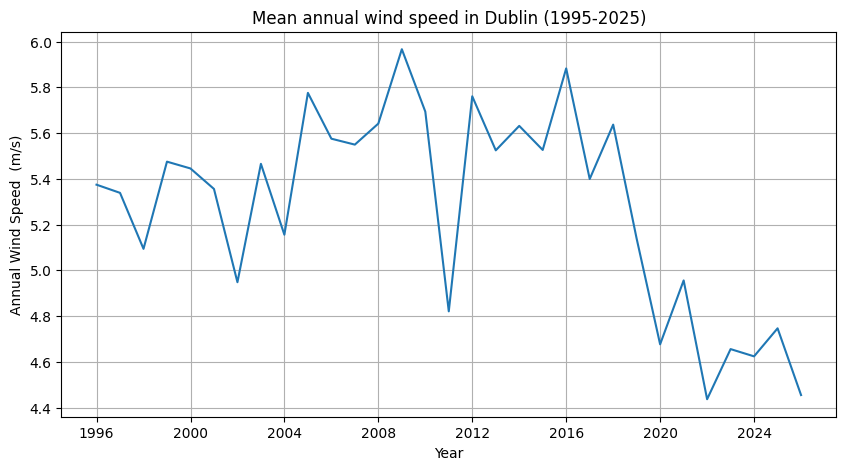

In [21]:
plt.figure(figsize=(10,5))
plt.plot(df_yearly.index, df_yearly.values)
plt.xlabel("Year")
plt.ylabel("Annual Wind Speed  (m/s)")
plt.title("Mean annual wind speed in Dublin (1995-2025)")
plt.grid(True)
plt.show()

We can visualize the historical distribution of wind speed during the last 30 years.

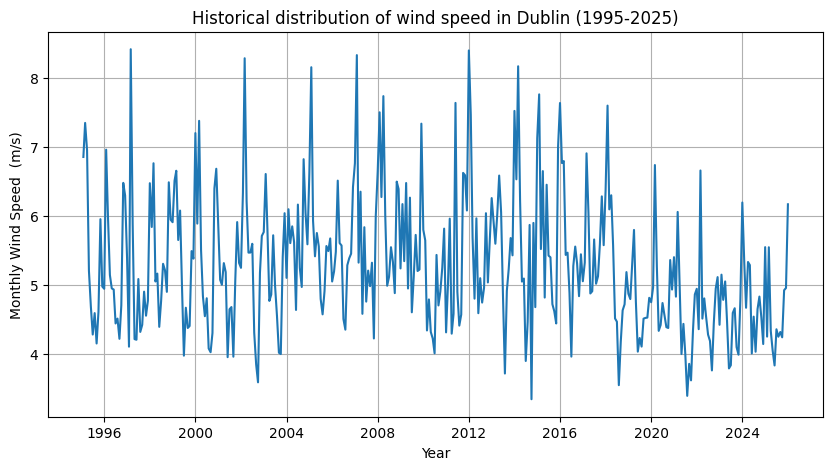

In [31]:
# historical distribution of wind speed
plt.figure(figsize=(10,5))
plt.plot(df_monthly.index, df_monthly.values)
plt.xlabel("Year")
plt.ylabel("Monthly Wind Speed  (m/s)")
plt.title("Historical distribution of wind speed in Dublin (1995-2025)")
plt.grid(True)

We can delve deeper by analysing whether wind speed can change during any period of the year, for example, a specific season.

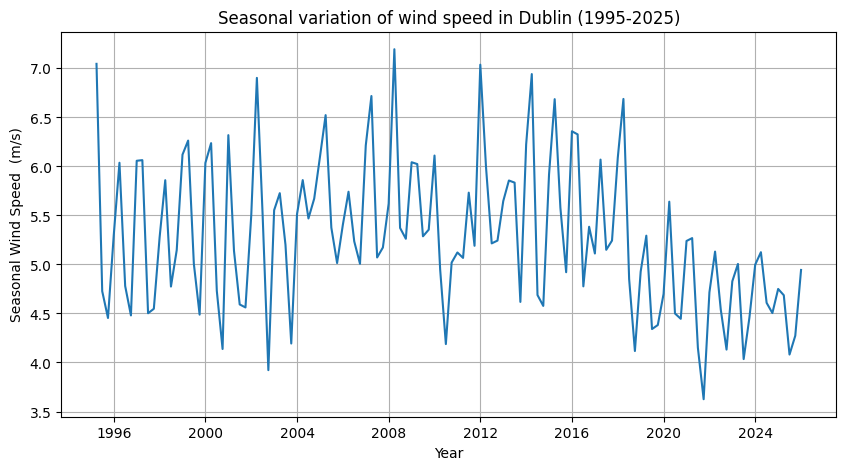

In [38]:
# season analysis of wind speed
'''using QE instad 'Q' as it will be deprecated in future versions'''
''' We use 'Q' to group by quarter'''
df_seasonal = df.resample('QE')['mean wind speed'].mean()
df_seasonal.head()

# plot the seasonal data
plt.figure(figsize=(10,5))
plt.plot(df_seasonal.index, df_seasonal.values)
plt.xlabel("Year")
plt.ylabel("Seasonal Wind Speed  (m/s)")
plt.title("Seasonal variation of wind speed in Dublin (1995-2025)")
plt.grid(True)
plt.show()


Now we can check the tendency during these three decades. This can help us to understand the changes over time, if the values are trending or if they decreased or they are stables.

In [23]:
# Calculate the tendency
nineties_wind = df_yearly.loc['1995':'2005'].mean()
late_wind  = df_yearly.loc['2015':'2025'].mean()

trend = (late_wind - nineties_wind) / 20
print(f"The tendency of wind speed in Dublin is {trend:.2f} m/s per year.")



The tendency of wind speed in Dublin is -0.02 m/s per year.


In [24]:
# Calculate the tendency per decade
trend_decade = trend * 10
print(f"The tendency of wind speed in Dublin is {trend_decade:.2f} m/s per decade.")

The tendency of wind speed in Dublin is -0.20 m/s per decade.


We can calculate the tendency per 30 years, to verify visualy how the values are during these three decades.

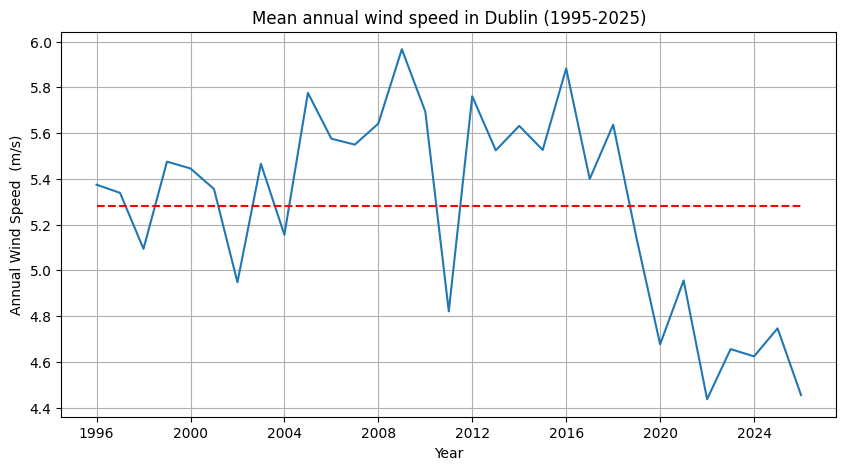

In [29]:
# plot the tendency
plt.figure(figsize=(10,5))
plt.plot(df_yearly.index, df_yearly.values, label='Mean annual wind speed')
early = df_yearly.loc['1995':'2025']
mean_early = early.mean()
plt.hlines(mean_early, early.index.min(), early.index.max(),
           linestyles='--', color='red', label="Media 1995–2025")
plt.xlabel("Year")
plt.ylabel("Annual Wind Speed  (m/s)")
plt.title("Mean annual wind speed in Dublin (1995-2025)")
plt.grid(True)

End